In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json

In [2]:
# Preprocess results from model_predict
with open('../flower_predictions.json', 'r') as json_file:
    flower_predictions = pd.DataFrame.from_records(json.load(json_file))
flower_predictions.head(2)

object_name  flower_box_id  \
0  0344-6782/2021-06-21/08/0344-6782_2021-06-21T0...              0   
1  0344-6782/2021-06-21/08/0344-6782_2021-06-21T0...              1   

                                          flower_box  flower_class  \
0  [1145.144775390625, 939.006591796875, 1197.426...             0   
1  [1250.1650390625, 1061.8956298828125, 1317.565...             0   

   flower_score flower_name  width  height  
0      0.915887       daisy     82      93  
1      0.913939       daisy     97     101

In [3]:
with open('../model_config.json', 'r') as json_file:
    model_config = json.load(json_file)
model_config

{'config_id': 'CONFIG002',
 'flower': {'weights_path': '.\\src\\etl\\Pollinatordetection\\models\\flowers_ds_v5_640_yolov5n_box_hyps_v0.pt',
  'class_names': ['daisy', 'wildemoere', 'flockenblume'],
  'confidence_threshold': 0.5,
  'iou_threshold': 0.45,
  'max_detections': 30,
  'margin': 15,
  'multi_label': False,
  'multi_label_iou_threshold': 0.7,
  'augment': False,
  'image_size': 640},
 'pollinator': {'weights_path': '.\\src\\etl\\Pollinatordetection\\models\\pollinators_ds_v6_480_yolov5s_hyps_v0.pt',
  'class_names': ['honigbiene',
   'wildbiene',
   'hummel',
   'schwebfliege',
   'fliege'],
  'confidence_threshold': 0.65,
  'iou_threshold': 0.45,
  'max_detections': 10,
  'margin': 50,
  'multi_label': False,
  'multi_label_iou_threshold': 0.45,
  'augment': False,
  'image_size': 480}}

In [5]:
result_ids = pd.read_csv('../checkpoint_df.csv')
result_ids.head(2)

file_id                                        object_name  result_id  \
0        2  0344-6782/2021-06-21/08/0344-6782_2021-06-21T0...        458   
1        3  0344-6782/2021-06-21/08/0344-6782_2021-06-21T0...        459   

    model_id  
0  CONFIG002  
1  CONFIG002

In [17]:
def process_flower_predictions(flower_predictions: dict, result_ids: pd.DataFrame, model_config: dict) -> pd.DataFrame:
    box_margin = model_config['flower']['margin']
    # Preprocess results from model_predict
    flower_predictions = pd.DataFrame.from_records(flower_predictions)
    
    # Join with DB data
    flower_predictions = pd.merge(
        left=result_ids, 
        right=flower_predictions, 
        left_on='object_name', 
        right_on='object_name', 
        how='right'
    )
    # extract bbox data
    flower_predictions['x0'] = flower_predictions['flower_box'].apply(lambda x: x[0]).astype(int)
    flower_predictions['y0'] = flower_predictions['flower_box'].apply(lambda x: x[1]).astype(int)
    flower_predictions['x1'] = flower_predictions['flower_box'].apply(lambda x: x[2]).astype(int)
    flower_predictions['y1'] = flower_predictions['flower_box'].apply(lambda x: x[3]).astype(int)
    
    # add box margin relative to width/heigth
    flower_predictions['x0'] = flower_predictions['x0'] - box_margin
    flower_predictions['y0'] = flower_predictions['y0'] - box_margin
    flower_predictions['x1'] = flower_predictions['x1'] + box_margin
    flower_predictions['y1'] = flower_predictions['y1'] + box_margin
    
    flower_predictions = flower_predictions.drop('flower_box', axis=1)

    return flower_predictions

result_ids = {obj_name:idx for idx, obj_name in enumerate(np.unique(flower_predictions['object_name'].to_list()))}
results = flower_predictions[['object_name']].copy()
results['result_id'] = flower_predictions['object_name'].replace(result_ids)
results

In [23]:
tmp = process_flower_predictions(
    flower_predictions=flower_predictions, 
    model_config=model_config, 
    result_ids=result_ids
)
tmp.head(2)

file_id                                        object_name  result_id  \
0        2  0344-6782/2021-06-21/08/0344-6782_2021-06-21T0...        458   
1        2  0344-6782/2021-06-21/08/0344-6782_2021-06-21T0...        458   

    model_id  flower_box_id  flower_class  flower_score flower_name  width  \
0  CONFIG002              0             0      0.915887       daisy     82   
1  CONFIG002              1             0      0.913939       daisy     97   

   height    x0    y0    x1    y1  
0      93  1130   924  1212  1017  
1     101  1235  1046  1332  1147

In [50]:
def draw_bbox(img_path, x0, x1, y0, y1):
    img = cv2.imread(img_path)[:,:,::-1]
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(10, 10))

    # Display the image
    ax.imshow(img)

    # Coordinates of rectangle vertices
    # in clockwise order
    xs = [x0, x1, x1, x0, x0]
    ys = [y0, y0, y1, y1, y0]
    ax.plot(xs, ys, color="red")

    plt.show()

Flower


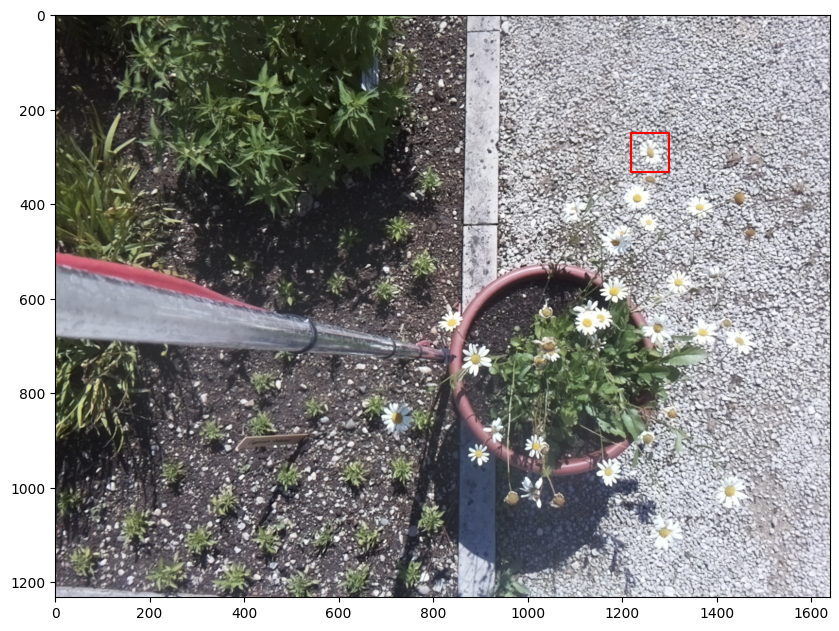

In [51]:
print('Flower')
sample = tmp.sample(1)
draw_bbox(
    '../' + sample['object_name'].iloc[0], 
    sample['x0'].iloc[0],
    sample['x1'].iloc[0], 
    sample['y0'].iloc[0], 
    sample['y1'].iloc[0]
)

In [52]:
# Preprocess results from model_predict
with open('../pollinator_predictions.json', 'r') as json_file:
    pollinator_predictions = pd.DataFrame.from_records(json.load(json_file))
pollinator_predictions.head(2)

object_name  flower_box_id  \
0  0344-6782/2021-06-21/08/0344-6782_2021-06-21T0...              9   
1  0344-6782/2021-06-21/08/0344-6782_2021-06-21T0...              5   

                                    pollinator_boxes  pollinator_classes  \
0  [35.54256057739258, 48.67624282836914, 46.5154...                   1   
1  [48.67750930786133, 35.599178314208984, 61.916...                   4   

   pollinator_scores pollinator_names  
0           0.702599        wildbiene  
1           0.661216           fliege

In [66]:
def process_pollinator_predictions(pollinator_predictions: dict, flower_predictions: pd.DataFrame):
    if isinstance(pollinator_predictions, dict):
        pollinator_predictions = pd.DataFrame.from_records(json.load(json_file))
    
    # Join with DB data
    # Merge with flowers to get size of BB
    pollinator_predictions = pd.merge(
        left=pollinator_predictions, 
        right=flower_predictions[['object_name', 'flower_box_id', 'result_id', 'x0', 'y0', 'x1', 'y1']], 
        left_on=['object_name', 'flower_box_id'], right_on=['object_name', 'flower_box_id'], 
        how='inner'
    )
    # rename columns
    pollinator_predictions = pollinator_predictions.rename(
        columns={
            'x0': 'f_x0', 'x1': 'f_x1',
            'y0': 'f_y0', 'y1': 'f_y1'
        }
    )
    # Calculate BBoxes given previous flower perdiction
    pollinator_predictions['p_x0'] = pollinator_predictions['pollinator_boxes'].apply(lambda x: x[0]).astype(int)
    pollinator_predictions['p_y0'] = pollinator_predictions['pollinator_boxes'].apply(lambda x: x[1]).astype(int)
    pollinator_predictions['p_x1'] = pollinator_predictions['pollinator_boxes'].apply(lambda x: x[2]).astype(int)
    pollinator_predictions['p_y1'] = pollinator_predictions['pollinator_boxes'].apply(lambda x: x[3]).astype(int)

    # new_xmin = flower_xmin + polli_xmin / new_ymin = flower_ymin + polli_ymin
    pollinator_predictions['x0'] = pollinator_predictions['f_x0'] + pollinator_predictions['p_x0']
    pollinator_predictions['y0'] = pollinator_predictions['f_y0'] + pollinator_predictions['p_y0']
    # new_xmax = new_xmin + polli_xmax / new_ymax = new_ymin + polli_ymax
    pollinator_predictions['x1'] = pollinator_predictions['f_x0'] + pollinator_predictions['p_x1']
    pollinator_predictions['y1'] = pollinator_predictions['f_y0'] + pollinator_predictions['p_y1']

    pollinator_predictions = pollinator_predictions.drop(
        [
            'p_x0', 'p_x1', 'p_y0', 'p_y1', 'f_x0', 'f_x1', 'f_y0',
            'f_y1', 'pollinator_boxes', 'pollinator_classes'
        ], 
        axis=1
    )

    return pollinator_predictions

In [67]:
tmp_polli = process_pollinator_predictions(
    pollinator_predictions=pollinator_predictions, 
    flower_predictions=tmp,
)

In [68]:
tmp_polli.head(2)

object_name  flower_box_id  \
0  0344-6782/2021-06-21/08/0344-6782_2021-06-21T0...              9   
1  0344-6782/2021-06-21/08/0344-6782_2021-06-21T0...              5   

   pollinator_scores pollinator_names  result_id    x0   y0    x1   y1  
0           0.702599        wildbiene        465  1256  298  1267  305  
1           0.661216           fliege        466  1277  654  1290  665

Pollinator


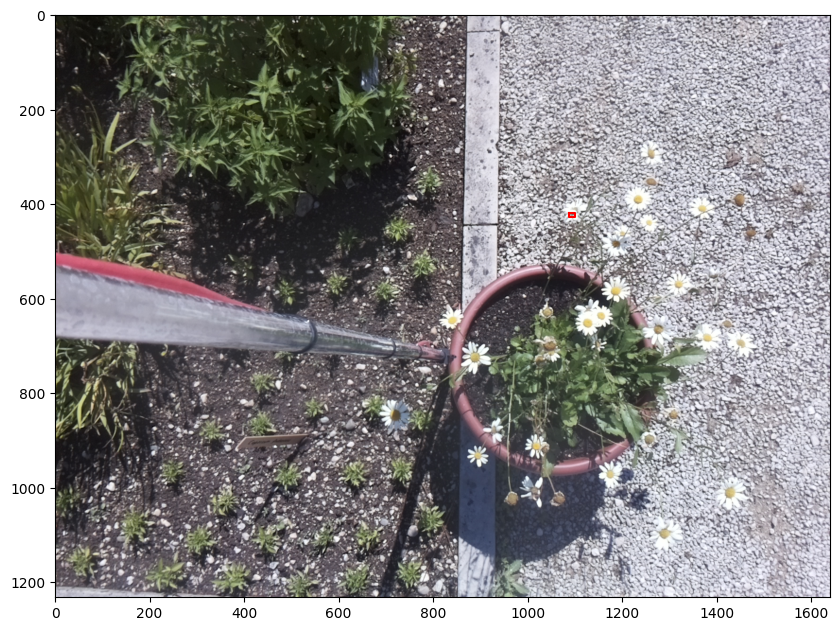

In [69]:
print('Pollinator')
sample = tmp_polli.sample(1)
draw_bbox(
    '../' + sample['object_name'].iloc[0], 
    sample['x0'].iloc[0],
    sample['x1'].iloc[0], 
    sample['y0'].iloc[0], 
    sample['y1'].iloc[0]
)

In [70]:
sample_flower = tmp[(tmp['object_name'] == sample['object_name'].iloc[0] )& (tmp['flower_box_id'] == sample['flower_box_id'].iloc[0])]

Flower


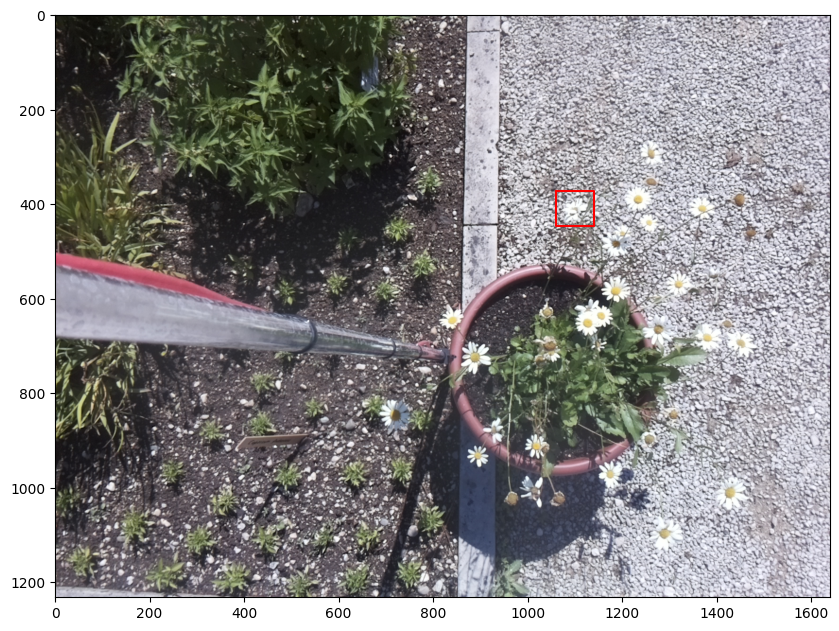

In [71]:
print('Flower')
draw_bbox(
    '../' + sample_flower['object_name'].iloc[0], 
    sample_flower['x0'].iloc[0],
    sample_flower['x1'].iloc[0], 
    sample_flower['y0'].iloc[0], 
    sample_flower['y1'].iloc[0]
)